<a href="https://colab.research.google.com/github/jagatabhay/TSAI/blob/master/S10/Gradcamp_S10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import copy
import cv2

#from model1 import *

In [0]:
import matplotlib.pyplot as plt
import numpy as np

In [0]:
import torch
import torch.nn.functional as F

from statistics import mode, mean


class SaveValues():
    def __init__(self, m):
        # register a hook to save values of activations and gradients
        self.activations = None
        self.gradients = None
        self.forward_hook = m.register_forward_hook(self.hook_fn_act)
        self.backward_hook = m.register_backward_hook(self.hook_fn_grad)

    def hook_fn_act(self, module, input, output):
        self.activations = output

    def hook_fn_grad(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def remove(self):
        self.forward_hook.remove()
        self.backward_hook.remove()


class CAM(object):
    """ Class Activation Mapping """

    def __init__(self, model, target_layer):
        """
        Args:
            model: a base model to get CAM which have global pooling and fully connected layer.
            target_layer: conv_layer before Global Average Pooling
        """

        self.model = model
        self.target_layer = target_layer

        # save values of activations and gradients in target_layer
        self.values = SaveValues(self.target_layer)

    def forward(self, x, idx=None):
        """
        Args:
            x: input image. shape =>(1, 3, H, W)
        Return:
            heatmap: class activation mappings of the predicted class
        """

        # object classification
        score = self.model(x)

        prob = F.softmax(score, dim=1)

        if idx is None:
            prob, idx = torch.max(prob, dim=1)
            idx = idx.item()
            prob = prob.item()
            print("predicted class ids {}\t probability {}".format(idx, prob))

        # cam can be calculated from the weights of linear layer and activations
        weight_fc = list(
            self.model._modules.get('fc').parameters())[0].to('cpu').data

        cam = self.getCAM(self.values, weight_fc, idx)

        return cam, idx

    def __call__(self, x):
        return self.forward(x)

    def getCAM(self, values, weight_fc, idx):
        '''
        values: the activations and gradients of target_layer
            activations: feature map before GAP.  shape => (1, C, H, W)
        weight_fc: the weight of fully connected layer.  shape => (num_classes, C)
        idx: predicted class id
        cam: class activation map.  shape => (1, num_classes, H, W)
        '''

        cam = F.conv2d(values.activations, weight=weight_fc[:, :, None, None])
        _, _, h, w = cam.shape

        # class activation mapping only for the predicted class
        # cam is normalized with min-max.
        cam = cam[:, idx, :, :]
        cam -= torch.min(cam)
        cam /= torch.max(cam)
        cam = cam.view(1, 1, h, w)

        return cam.data


class GradCAM(CAM):
    """ Grad CAM """

    def __init__(self, model, target_layer):
        super().__init__(model, target_layer)

        """
        Args:
            model: a base model to get CAM, which need not have global pooling and fully connected layer.
            target_layer: conv_layer you want to visualize
        """

    def forward(self, x, idx=None):
        """
        Args:
            x: input image. shape =>(1, 3, H, W)
            idx: ground truth index => (1, C)
        Return:
            heatmap: class activation mappings of the predicted class
        """

        # anomaly detection
        score = self.model(x)

        prob = F.softmax(score, dim=1)

        if idx is None:
            prob, idx = torch.max(prob, dim=1)
            idx = idx.item()
            prob = prob.item()
            print("predicted class ids {}\t probability {}".format(idx, prob))

        # caluculate cam of the predicted class
        cam = self.getGradCAM(self.values, score, idx)

        return cam, idx

    def __call__(self, x):
        return self.forward(x)

    def getGradCAM(self, values, score, idx):
        '''
        values: the activations and gradients of target_layer
            activations: feature map before GAP.  shape => (1, C, H, W)
        score: the output of the model before softmax
        idx: predicted class id
        cam: class activation map.  shape=> (1, 1, H, W)
        '''

        self.model.zero_grad()

        score[0, idx].backward(retain_graph=True)

        activations = values.activations
        gradients = values.gradients
        n, c, _, _ = gradients.shape
        alpha = gradients.view(n, c, -1).mean(2)
        alpha = alpha.view(n, c, 1, 1)

        # shape => (1, 1, H', W')
        cam = (alpha * activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam -= torch.min(cam)
        cam /= torch.max(cam)

        return cam.data


In [0]:
from google.colab import files
files.upload()

Saving resnetmodel.py to resnetmodel.py


{'resnetmodel.py': b'import torch\r\nimport torch.nn as nn\r\nimport torch.nn.functional as F\r\n\r\n\r\nclass BasicBlock(nn.Module):\r\n    expansion = 1\r\n\r\n    def __init__(self, in_planes, planes, stride=1):\r\n        super(BasicBlock, self).__init__()\r\n        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)\r\n        self.bn1 = nn.BatchNorm2d(planes)\r\n        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,stride=1, padding=1, bias=False)\r\n        self.bn2 = nn.BatchNorm2d(planes)\r\n        self.shortcut = nn.Sequential()\r\n        if stride != 1 or in_planes != self.expansion*planes:\r\n            self.shortcut = nn.Sequential(nn.Conv2d(in_planes, self.expansion*planes,kernel_size=1, stride=stride, bias=False),\r\n                                          nn.BatchNorm2d(self.expansion*planes)\r\n                                          )\r\n\r\n    def forward(self, x):\r\n        out = F.relu(self.bn1(self.conv1(

In [0]:
from resnetmodel import *

In [0]:
from google.colab import files
files.upload()

In [0]:
from main3 import *

In [0]:
from google.colab import files
files.upload()

Saving transform.py to transform.py


{'transform.py': b'# -*- coding: utf-8 -*-\n"""transform.ipynb\n\nAutomatically generated by Colaboratory.\n\nOriginal file is located at\n    https://colab.research.google.com/drive/1TqmrjYL4uAax4RlQ5PmpApY20cq2QS_T\n"""\n\nimport torch\nimport torchvision\nimport torchvision.transforms as transforms\nimport torch.nn as nn\nimport torch.nn.functional as F\n\nmean = (0.4914, 0.4822, 0.4465)\nstd = (0.2023, 0.1994, 0.2010)\n\ntrans = transforms.Compose([ transforms.ToTensor(),\n                             transforms.Normalize(mean, std)\n                            ])\n\nfrom albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, VerticalFlip, Resize,Rotate , Cutout\nfrom albumentations.pytorch import ToTensor\nimport numpy as np\n\nclass train_transforms():\n\n    def __init__(self):\n        self.albTrainTransforms = Compose([  # Resize(256, 256),\n            Rotate((-10.0, 10.0)),\n            HorizontalFlip(p=0.5),\n            VerticalFlip(p=0.5),\n            Cuto

In [0]:
from transform import *

REQUIRED LIBRARIES LOADED...


In [0]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
net = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

model_save_name = 'S10_Assignment_Model.pt' 
path = F"/content/gdrive/My Drive/{model_save_name}"
net.load_state_dict(torch.load(path))  # loading the model
net.eval()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [0]:
target_layer = net.layer4[1].conv2

In [0]:
wrapped_model = GradCAM(net, target_layer)

In [0]:




trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True,
                                        download=True, 
                                        transform=train_transforms() )
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=30,
                                          shuffle=True,
                                          num_workers=4, 
                                          pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False,
                                       download=True, 
                                       transform=trans)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=30,
                                         shuffle=False, 
                                         num_workers=4, 
                                         pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
'''trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=30,
                                          shuffle=True,num_workers=4, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=30,
                                         shuffle=False, num_workers=4, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')'''

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


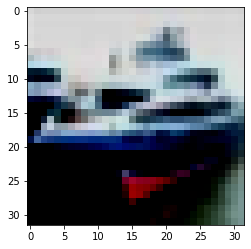

In [0]:
dataiter=iter(testloader)
images, labels = next(dataiter)
images=images.numpy()
image=np.transpose(images[1], (1, 2, 0))
plt.imshow(image)


In [0]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

In [0]:
tensor = preprocess(data)

# reshape 4D tensor (N, C, H, W)
#tensor = tensor.unsqueeze(0)

In [0]:
tensor=tensor.to(device)

In [0]:
cam, idx = wrapped_model(tensor)

predicted class ids 1	 probability 0.18863654136657715


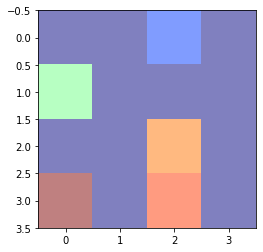

In [0]:
plt.imshow(cam.cpu().squeeze().numpy(), alpha=0.5, cmap='jet')

In [0]:
from google.colab import files
files.upload()

Saving utils.py to utils.py


{'utils.py': b'# -*- coding: utf-8 -*-\n"""utils.ipynb\n\nAutomatically generated by Colaboratory.\n\nOriginal file is located at\n    https://colab.research.google.com/drive/1SxgR1BdgpjdDjlnLWO2awFWQk9TjtiIK\n"""\n\nimport torch\nimport torch.nn.functional as F\n\nimport numpy as np\nimport cv2\n\n\ndef reverse_normalize(x, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):\n    x[:, 0, :, :] = x[:, 0, :, :] * std[0] + mean[0]\n    x[:, 1, :, :] = x[:, 1, :, :] * std[1] + mean[1]\n    x[:, 2, :, :] = x[:, 2, :, :] * std[2] + mean[2]\n    return x\n\n\ndef visualize(img, cam):\n    """\n    Synthesize an image with CAM to make a result image.\n    Args:\n        img: (Tensor) shape => (1, 3, H, W)\n        cam: (Tensor) shape => (1, 1, H\', W\')\n    Return:\n        synthesized image (Tensor): shape =>(1, 3, H, W)\n    """\n\n    _, _, H, W = img.shape\n    cam = F.interpolate(cam, size=(H, W), mode=\'bilinear\', align_corners=False)\n    cam = 255 * cam.squeeze()\n    heatmap = 

In [0]:
from utils import *

In [0]:
img = reverse_normalize(tensor)

In [0]:
heatmap = visualize(img.cpu(), cam.cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


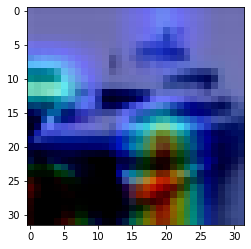

In [0]:
hm = (heatmap.squeeze().numpy().transpose(1, 2, 0))
plt.imshow(hm)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

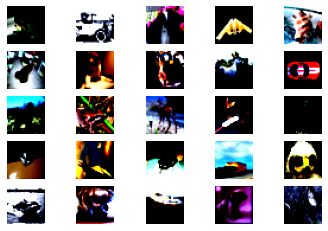

In [0]:
    #train_loader,testloader = loading_of_dataset2()
    dataiter = iter(testloader)
    #data,target = dataiter.next()
    #data, target = data.to(device), target.to(device)
    #output = model(data)
    #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
    #pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    #print(pred)
    #print()
    #correct += pred.eq(target.view_as(pred)).sum().item()
    figure = plt.figure()
    #plt.title('Misclassified images when using BN')
    #no_of_images=25
    count=0
    #print("with BN misclassified image")
   
    while(count<25):
          data,target = dataiter.next()
          #data=data.numpy()
          #data=np.transpose(data, (1, 2, 0))
          device = 'cuda' if torch.cuda.is_available() else 'cpu'
          #model=summary_of_model2()
          model = net.to(device)
          #model_save_name = 'S6_Assignment_Misclasssified_BN.pt' 
          #path = F"/content/gdrive/My Drive/{model_save_name}"
          #model.load_state_dict(torch.load(path))  # loading the model
          model.eval()
          
          data, target = data.to(device), target.to(device)
          output = model(data)
          #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
          _, predicted = torch.max(output.data, 1)
            # get the index of the max log-probability
          data=data.cpu().numpy()
          #data=np.transpose(data, (1, 2, 0))

          
          for a in range(30):
              if(predicted[a]!=target[a]):
                 #print("pred",pred[a])
                 #print("targ",target[a])
                 plt.subplot(5,5,count+1)
                 plt.axis('off')
                 
                 plt.imshow(data[a].squeeze().transpose(1, 2, 0))
                 count=count+1

              if(count==25):
                  break